# Introduction to Q-Exponential Process (QEP)

In this notebook, we will introduce the q-exponential process (QEP) as a novel stochastic process which imposes regularization (through a parameter `q>0`) on function spaces and includes Gaussian process as a special case (with `q=2`). This is mainly due to [Li, Shuyi, Michael O’Connor, Shiwei Lan (2023)](https://papers.nips.cc/paper_files/paper/2023/hash/e6bfdd58f1326ff821a1b92743963bdf-Abstract-Conference.html).

In particular, we will explain:

- What is q-exponential process?
- Why do we need q-exponential process?
- How do we fit QEP models in QPyTorch?

## What is Q-Exponential Process (QEP)?

Q-Exponential process (QEP), denoted as $\mathcal{Q}(\mu, \mathcal C)$, is a stochastic process parameterized by three parameters:

- mean function $\mu$;
- covariance kernel $\mathcal C$;
- power parameter $q>0$.

It is defined as a collection of random variables whose any subsect follows a (scaled) multivariate q-exponential distribution. Given any finite points $x_1,\cdots, x_d$, a function $u(x)\sim \mathcal{Q}(\mu, \mathcal C)$ from QEP evaluated on these points, ${\bf u}=(u(x_1),\cdots, u(x_d))$ follows $d$-dimensional (scaled) q-exponential distribution, denoted as ${\bf u}\sim \mathcal{Q}_d(\boldsymbol{\mu}, {\bf C})$, which has the following probability density:

\begin{equation*}
p({\bf u}|\boldsymbol{\mu}, {\bf C}, q) = \frac{q}{2} (2\pi)^{-\frac{d}{2}} |{\bf C}|^{-\frac{1}{2}} r^{(\frac{q}{2}-1)\frac{d}{2}} \exp\left\{-\frac{r^\frac{q}{2}}{2}\right\}, \quad
r({\bf u}) = ({\bf u}-\boldsymbol{\mu})^\top {\bf C}^{-1} ({\bf u}-\boldsymbol{\mu})
\end{equation*}

In practice, we define QEP $u(\cdot)$ with scaled ${\bf u}$ by a factor, ${\bf u}^*=d^{\frac{1}{2}-\frac{1}{q}}{\bf u}$, which has asymptotically finite covariance. **When q=2, it reduces to Gaussian**.

In QPyTorch, we have `qpytorch.distributions.QExponential` and `qpytorch.distributions.MultivaraiteQExponential` for univariate and multivariate q-exponential random variables resepectively. We can plot their densities for different $q$s. 


[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library 'libomp' not found.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


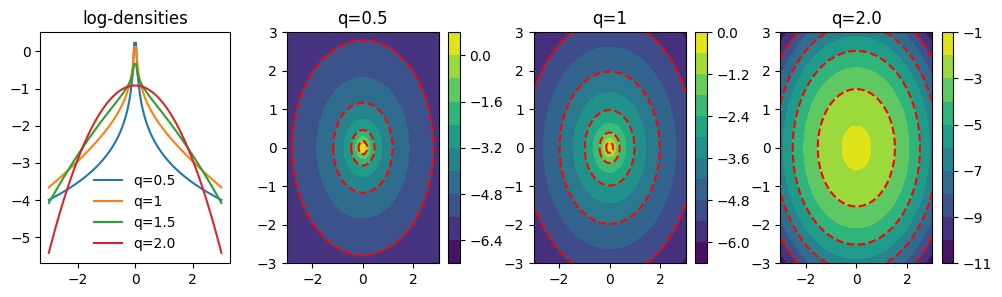

In [1]:
# import pacakges
import numpy as np
import torch
import qpytorch
from matplotlib import pyplot as plt

%matplotlib inline

fig, ax = plt.subplots(1, 4, figsize=(12, 3))

n = 100
x = torch.linspace(-3,3, n)
qep = qpytorch.distributions.QExponential(torch.tensor(0), torch.tensor(1), torch.tensor(1.0))
for q in [0.5, 1, 1.5, 2.0]:
    qep.power = torch.tensor(q)
    ax[0].plot(x, qep.log_prob(x))
ax[0].legend(['q='+str(i) for i in [0.5, 1, 1.5, 2.0]], frameon=False)
ax[0].set_title('log-densities')

nx = ny = 50
x = torch.linspace(-3,3, nx)
y = torch.linspace(-3,3, ny)

X, Y = torch.meshgrid(x, y, indexing='ij')
qep = qpytorch.distributions.MultivariateQExponential(torch.zeros(2), torch.eye(2), torch.tensor(1.0))
for i, q in enumerate([0.5, 1, 2.0]):
    qep.power = torch.tensor(q)
    Z = qep.log_prob(torch.stack([X.flatten(), Y.flatten()], dim=1)).reshape(nx, ny)
    contf = ax[i+1].contourf(X, Y, Z, levels=10)
    ax[i+1].contour(contf, levels=contf.levels[::2], colors='r')
    ax[i+1].set_title('q='+str(q))
    fig.colorbar(contf, ax=ax[i+1])

plt.subplots_adjust(wspace=0.3)

None

When $0<q<2$, the density is log-convex in $r$ and heavy-tailed; when $q>2$, the density is log-concave in $r$ and light-tailed. Negative log-density is dominated by some weighted $L_q$ norm of ${\bf u}-\boldsymbol{\mu}$, i.e. $\Vert {\bf u}-\boldsymbol{\mu}\Vert_{\bf C}$, which serves as an $L_q$ regularization term when QEP is used as a prior in Bayesian modeling.

### Bayesian Modeling with Q-Exponential Process

Consider the generic Bayesian regression model:

\begin{align*}
y &= u(x)+\epsilon, \quad \epsilon \sim L(\cdot;0,\Sigma) \\
u &\sim \mu_0(du)
\end{align*}

where $L(\cdot;0,\Sigma)$ denotes some likelihood model with zero mean and covariance $\Sigma$, and the mean function $u$ is given a QEP prior.
Theorem 3.5 in Li et~al (2023) proves the following tractable posterior predictive formula.

[**Posterior Prediction Theorem**]
Given covariates ${\bf x}=\{x_i\}_{i=1}^N$ and observations ${\bf y}=\{y_i\}_{i=1}^N$ following mutlivariate q-exponential distribution, i.e., $L(\cdot;0,\Sigma) \sim \mathcal{Q}(0, \Sigma)$, in the above model with QEP prior for the same $q>0$, we have the following posterior predictive distribution for $u(x_*)$ at (a) new point(s) $x_*$:

\begin{align*}
u(x_*)|{\bf y,{\bf x},x_* \sim \mathcal{Q}(\boldsymbol{\mu}^*, {\bf C}^*), \quad
\boldsymbol{\mu}^* = {\bf C}^\top_* ({\bf C} + \Sigma)^{-1} {\bf y}, \quad
{\bf C}^* = {\bf C}_{**} - \{\bf C}^\top_* ({\bf C} + \Sigma)^{-1} {\bf C}_*
\end{align*}

where ${\bf C}=\mathcal{C}({\bf x},{\bf x})$, ${\bf C}_*=\mathcal{C}({\bf x},x_*)$, and ${\bf C}_{**}=\mathcal{C}(x_*,x_*)$.

### Sampling

When $L(\cdot;0,\Sigma)$ is not q-exponential, there is no conjugacy in general. We could apply Bayesian inference methods for which q-exponential random vector ${\bf u}\sim \mathcal Q_d(\boldsymbol{\mu}, {\bf C})$ can be sampled as follows:

\begin{equation*}
{\bf u} \overset{d}{=} \boldsymbol{\mu} + R {\bf L} S 
\end{equation*}

where $S\sim \mathrm{unif}(\mathcal{S}^{d+1})$ uniformly distributed on the unit-sphere $\mathcal{S}^{d+1}$, ${\bf L}$ is the Cholesky factor of ${\bf C}$ such that ${\bf C}={\bf L}{\bf L}^\top$, $R\perp S$ and $R^q\sim \chi^2(d)$.

## Why Q-Exponential Process?

Despite the popularity, GP tends to oversmooth modeling objects, e.g. edges in an image.
When $q<2$, QEP imposes stronger regularization than GP as a prior. Numerically, QEP has advantages over GP in modeling inhomogeneous objects with abrupt changes or sharp contrast. For example, in imaging analysis, QEP is often adopted with $q=1$ as an edge-preserving prior.

For example, we want to reconstruct an image of satellite from the following blurred observation.


<!-- ![title](../00_Basic_Usage/satallite_truth_obs.png) -->
<img src="./satallite_truth_obs.png" width="500" height="250" />


When using QEP as a prior, smaller $q$ tends to impose stronger regularization and hence yields sharper reconstruction.


<!-- ![title](./statellite_reconstructions.png) -->
<img src="../00_Basic_Usage/statellite_reconstructions.png" width="1000" height="250" />


QEP is closed under linear combination, i.e. linear combination of q-exponential random variables is still q-exponential. Therefore, QEP can be used to model objects with derivative information as GP. Since QEP imposes stronger regularization on gradients with $q<2$, it also outperforms GP in modeling with derivatives. One can check this example of [2d modeling with derivative infornation](../07_QEP_Modeling_with_Derivatives/Simple_QEP_Regression_Derivative_Information_2d.ipynb) for more details.


Therefore, QEP can find its applications in many statistics and machinear learning problems and is superior than GP in modeling inhomogeneous objects:

* Bayesian modeling [Li, S., M. O'Connor, and S. Lan. "Bayesian Learning via Q-Exponential Process." NIPS (2023)](https://papers.nips.cc/paper_files/paper/2023/hash/e6bfdd58f1326ff821a1b92743963bdf-Abstract-Conference.html)
* Regularizing latent representations [Obite, C. P., Z. Chang, K. Wu, and S. Lan.  "Bayesian Regularization on Latent Representation." ICLR (2025)](https://openreview.net/pdf?id=VOoJEQlLW5)
* Deep probabilistic models [Chang, Z., C. P. Obite, S. Zhou, and S. Lan.  "Deep Q-Exponential Processes. " AABI (2025)](https://openreview.net/pdf?id=gV82fQTpqq)
* Modeling with derivatives
* and so on...


## How to fit QEP models in QPyTorch?

QPyTorch is built on [PyTorch](https://pytorch.org) and [GPyTorch](https://gpytorch.ai) and provides comprehensive defining classes and modules. In particular, QPyTorch closely follows GPyTorch (which implements GP models) and mainly bases its inference on variational Bayes. Inherited from GPyTorch, QPyTorch can also run on [GPU](../02_Scalable_Exact_QEPs/index.html#exact-qeps-with-gpu-acceleration) and provides integration with [NUTS](../01_Exact_QEPs/QEP_Regression_Fully_Bayesian.ipynb) and Pyro (not fully tested).

Interested users can start from this [QPyTorch Regression Tutorial](../01_Exact_QEPs/Simple_QEP_Regression.ipynb).